# DBSCAN on Amazon Food Reviews
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector by taking 10k data points using two techniques: **<br>
**1. Average W2V.**<br>
**2. TFIDF-W2V.**<br>

**Then perform following tasks under each technique:**<br>
**Task 1. Perform Cross Validation on DBSCAN and use elbow method to find optimal value of Eps(Cluster Radius).**<br>
**Task 2. Apply DBSCAN by taking Min-Points equal to two times the dimension of reviews.**<br>
**Task 3. Try DBSCAN by taking different values of Eps which are close to the optimal value of Eps.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [3]:
connection = sqlite3.connect("FinalAmazonFoodReviewsDataset.sqlite")

In [4]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [6]:
data.shape

(364171, 12)

In [7]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [8]:
def changing(score):
    if score == "Positive":
        return 1
    else:
        return 0

In [9]:
# changing score
# Positive = 1
# Negative = 0
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changing, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [10]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [11]:
#taking 5000 random samples
data = data.sample(n = 10000)

In [12]:
data.shape

(10000, 12)

In [13]:
data["Score"].value_counts()

1    8360
0    1640
Name: Score, dtype: int64

In [14]:
Data = data

In [15]:
Data_Labels = data["Score"]

In [16]:
print(Data.shape)
print(Data_Labels.shape)

(10000, 12)
(10000,)


In [17]:
Data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
317902,457006,494139,B001EPPRK8,A1GGQA5X4O455,SkyphotoX,0,0,0,1334707200,Bad Container,"So the salt is fine, but the poorly designed ""...",the salt fine but the poor design cylind not v...
58531,82315,89518,B004L44PHU,A2WRSERHIOLA5V,Ace,0,0,1,1323561600,Keeps me full and it tastes great!,"This is the best protein shake out there, not ...",this the best protein shake out there not onli...
113533,160227,173699,B000I3RLVK,AAS353KFPRH0O,GH,1,2,0,1298073600,Received a Substitute,Whereas the Savu Smoker Bag is an excellent pr...,wherea the savu smoker bag excel product was d...
74564,105927,115014,B007WP403O,A381XFLGN0NDPN,"Lorena Morales ""chnkymnky24""",0,0,1,1340755200,Perfect for toddlers,This product is perfect. I had trouble weening...,this product perfect had troubl ween son off h...
299103,430634,465718,B0032GC6L0,A1SXDQFRL24AZX,Bonzo,0,0,1,1334966400,Best Seed Company in America,Love the customer service...great ethical comp...,love the custom servic great ethic compani was...


# Average W2V

In [21]:
i = 0
listOfSentences = []
for sentence in Data["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [22]:
print(Data['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

the salt fine but the poor design cylind not veri sturdi and today while pour some salt into soup was make the lid came apart from the canist and pour the whole contain into soup obvious ruin buy someth els and save yourself the hassl also came complet clump


[['the', 'salt', 'fine', 'but', 'the', 'poor', 'design', 'cylind', 'not', 'veri', 'sturdi', 'and', 'today', 'while', 'pour', 'some', 'salt', 'into', 'soup', 'was', 'make', 'the', 'lid', 'came', 'apart', 'from', 'the', 'canist', 'and', 'pour', 'the', 'whole', 'contain', 'into', 'soup', 'obvious', 'ruin', 'buy', 'someth', 'els', 'and', 'save', 'yourself', 'the', 'hassl', 'also', 'came', 'complet', 'clump'], ['this', 'the', 'best', 'protein', 'shake', 'out', 'there', 'not', 'onli', 'afford', 'but', 'tast', 'great', 'this', 'great', 'for', 'work', 'when', 'dont', 'have', 'time', 'eat', 'lunch', 'this', 'will', 'keep', 'full', 'for', 'hour', 'would', 'recommend', 'this', 'shake', 'anyon', 'and', 'love', 'drink', 'this', 'after', 'work

In [21]:
w2vModel = gensim.models.Word2Vec(listOfSentences, size=200, min_count=5, workers=4)

In [22]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(200)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    if TotalWordsPerSentence!= 0:
        sentenceVector /= TotalWordsPerSentence
        sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
200


In [23]:
Data_W2V_Std = StandardScaler(with_mean = False).fit_transform(sentenceAsW2V)
print(Data_W2V_Std.shape)
print(type(Data_W2V_Std))

(10000, 200)
<class 'numpy.ndarray'>


## Task 1. Perform Cross Validation on DBSCAN and use elbow method to find optimal value of Eps(Cluster Radius).

**Min points is equal to two times the number of dimensions of points.**

In [24]:
model = NearestNeighbors(n_neighbors=400, metric = "euclidean")
model.fit(Data_W2V_Std)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=400, p=2, radius=1.0)

In [25]:
dist_index = model.kneighbors(n_neighbors=400, return_distance=True)
dist_index

(array([[ 9.76605733,  9.84977324,  9.88970021, ..., 16.74794366,
         16.75899637, 16.7590867 ],
        [ 7.99772619,  8.12139865,  8.27241858, ..., 11.41261182,
         11.41345896, 11.41390497],
        [ 5.65158338,  5.79369597,  6.19634926, ...,  9.25257593,
          9.2529535 ,  9.25322454],
        ...,
        [ 6.60476602,  7.08243374,  7.24005662, ..., 10.74139544,
         10.7425087 , 10.74382498],
        [ 5.93690341,  5.94600806,  6.0067528 , ...,  9.20811107,
          9.21527515,  9.21621534],
        [ 7.97451401,  8.19097225,  8.23323698, ..., 11.88698223,
         11.88778255, 11.89162603]]),
 array([[6288, 7012, 4772, ..., 4752, 1521,  575],
        [8714, 4448,  164, ..., 8120, 6011, 5621],
        [3651, 5786, 1690, ..., 9968, 2413, 5618],
        ...,
        [5693,  990, 7483, ..., 3924, 7474, 3188],
        [6573, 8417, 3392, ..., 8169, 6528, 2869],
        [7941, 3778, 2497, ..., 4462, 1382, 5677]], dtype=int64))

In [26]:
dist = []
for i in range(len(dist_index[0])):
    dist.append(dist_index[0][i][399])

In [30]:
pointIndex = np.arange(10000)

In [31]:
dist_sorted = sorted(dist, reverse = False)

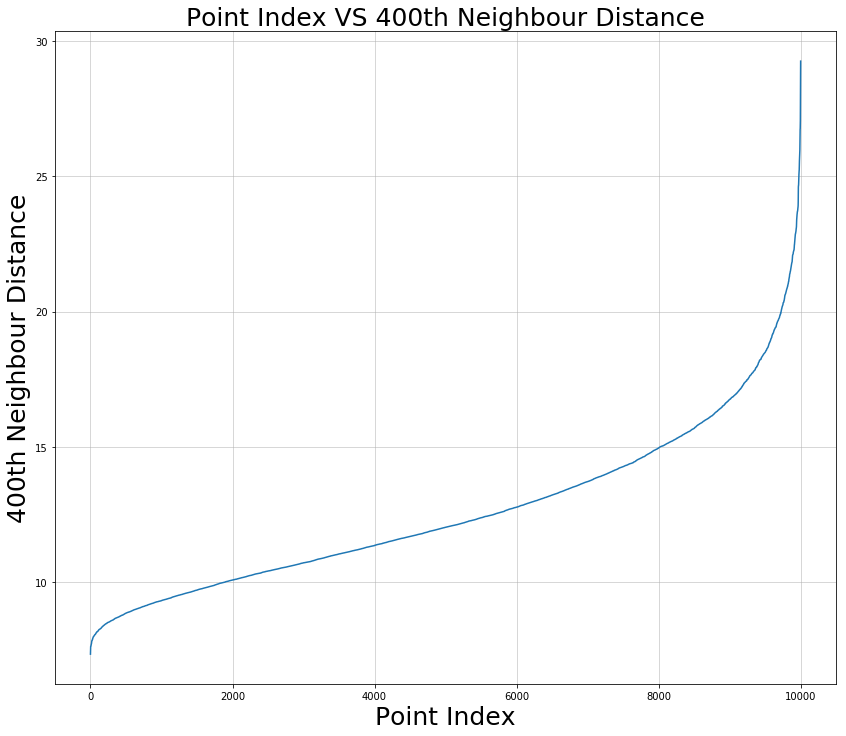

In [32]:
plt.figure(figsize = (14, 12))
plt.plot(pointIndex, dist_sorted)
plt.title("Point Index VS 400th Neighbour Distance", fontsize=25)
plt.xlabel("Point Index", fontsize=25)
plt.ylabel("400th Neighbour Distance", fontsize=25)
plt.grid(linestyle='-', linewidth=0.5)

**By above graph, it can clearly be seen that roughly from distance value of 18 onwards at y-axis the distance value increases very rapidly for further points. At distance value 18 there is an inflection point. Therefore, we are considering our epsilon value to be 18**

## Task 2. Apply DBSCAN by taking Min-Points equal to two times the dimension of reviews.

In [33]:
dbscan = DBSCAN(eps=18, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_W2V_Std)
silhouetteScore = silhouette_score(Data_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.43043455858573815
Number of clusters = 1


**Silhouette Score of 0.430 indicates that clusters are well separated from each other except few cluster which are overlapping. Furthermore, points are also correctly assigned to their respective clusters**

## Task 3. Try DBSCAN by taking different values of Eps which are close to the optimal value of Eps.

If you increase the Eps value to very high value then all of the points will come under one cluster and silhouette score metric will give error because there needs to be at least two clusters in order to calculate silhouette score.

Now as you can see below that there is only one cluster and still I have calculated silhouette score and it is not giving error. This is because as you already know that "labels_" attribute of DBSCAN returns '-1' for the noise points so here what happens is that except few points which are noisy points, rest of the points are under one cluster and silhouette score considers all the noisy points as under another another cluster, and hence accordingly it is doing the calculation of silhouette score based on two clusters. But actually calculating silhouette score here is useless as long as first, there is only one cluster and secondly, '-1' shouldn't be removed from 'label_' attribute.

In [34]:
#Taking eps value of 17
dbscan2 = DBSCAN(eps=17, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_W2V_Std)
silhouetteScore2 = silhouette_score(Data_W2V_Std, dbscan2.labels_)
print("Silhouette Score = "+str(silhouetteScore2))
labels = dbscan2.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.40773012443965956
Number of clusters = 1


In [35]:
#Taking eps value of 17.5
dbscan3 = DBSCAN(eps=17.5, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_W2V_Std)
silhouetteScore3 = silhouette_score(Data_W2V_Std, dbscan3.labels_)
print("Silhouette Score = "+str(silhouetteScore3))
labels = dbscan3.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.4119320101340016
Number of clusters = 1


In [36]:
#Taking eps value of 18.5
dbscan4 = DBSCAN(eps=18.5, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_W2V_Std)
silhouetteScore4 = silhouette_score(Data_W2V_Std, dbscan4.labels_)
print("Silhouette Score = "+str(silhouetteScore4))
labels = dbscan4.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.4308658281474539
Number of clusters = 1


In [37]:
#Taking eps value of 19
dbscan5 = DBSCAN(eps=19, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_W2V_Std)
silhouetteScore5 = silhouette_score(Data_W2V_Std, dbscan5.labels_)
print("Silhouette Score = "+str(silhouetteScore5))
labels = dbscan5.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.43835350237829734
Number of clusters = 1


# TFIDF-W2V

In [18]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [19]:
print(tfidf.shape)
print(type(tfidf))

(10000, 235101)
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=200, min_count=5, workers=4)

In [24]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(200)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

In [25]:
Data_TFIDF_W2V_Std = StandardScaler().fit_transform(tfidf_w2v)
print(Data_TFIDF_W2V_Std.shape)
print(type(Data_TFIDF_W2V_Std))

(10000, 200)
<class 'numpy.ndarray'>


## Task 1. Perform Cross Validation on DBSCAN and use elbow method to find optimal value of Eps(Cluster Radius).

In [26]:
model = NearestNeighbors(n_neighbors=400, metric = "euclidean")
model.fit(Data_TFIDF_W2V_Std)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=400, p=2, radius=1.0)

In [27]:
dist_index = model.kneighbors(n_neighbors=400, return_distance=True)
dist_index

(array([[ 4.76643929,  5.80134979,  6.34407323, ..., 10.89142541,
         10.89161216, 10.89276026],
        [ 8.83539736,  8.98451686,  9.07416661, ..., 13.55005226,
         13.55233361, 13.5575907 ],
        [ 4.41103054,  4.78774521,  5.16616908, ...,  8.8717598 ,
          8.87657041,  8.8792451 ],
        ...,
        [ 6.33844515,  6.40446094,  6.43622593, ...,  9.10897924,
          9.11120511,  9.11493847],
        [ 5.78473641,  5.8437839 ,  6.39851372, ...,  9.92660268,
          9.94129218,  9.94737831],
        [ 8.50451551,  8.80720263,  8.94185785, ..., 13.17745896,
         13.17852723, 13.18582603]]),
 array([[7932, 2629, 4266, ..., 1397,  990, 8772],
        [6419, 3943,   53, ..., 6189,  569,  156],
        [9068,  870, 4229, ..., 9044, 5420, 2675],
        ...,
        [5028, 1563, 7987, ..., 6869,   99, 3759],
        [6207, 4786, 6141, ..., 1750, 5115, 1219],
        [8942, 4842, 3536, ..., 8740, 2682, 5541]], dtype=int64))

In [28]:
dist = []
for i in range(len(dist_index[0])):
    dist.append(dist_index[0][i][399])

In [29]:
pointIndex = np.arange(10000)

In [30]:
dist_sorted = sorted(dist, reverse = False)

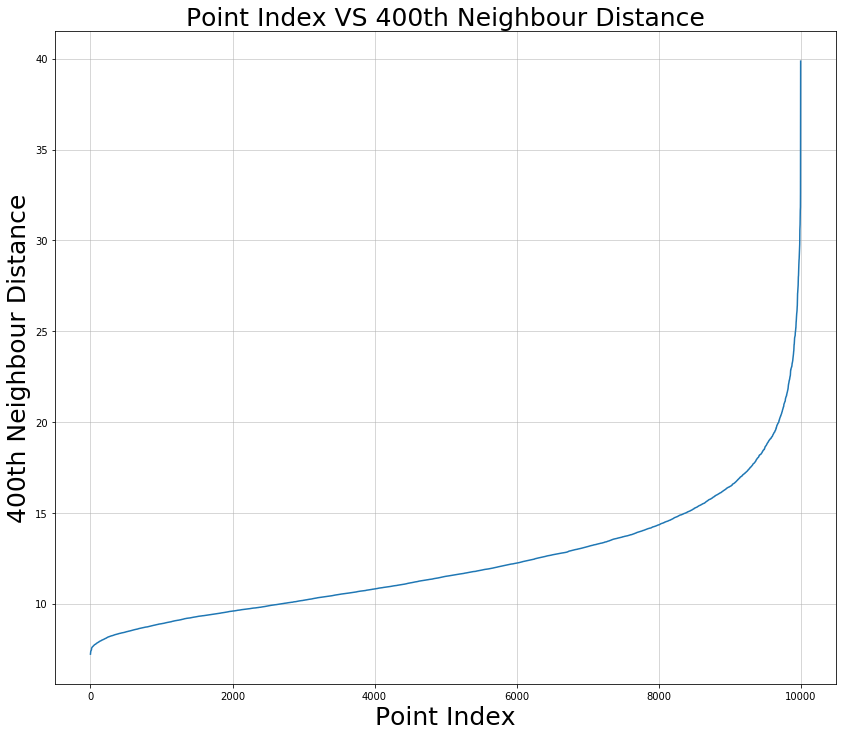

In [31]:
plt.figure(figsize = (14, 12))
plt.plot(pointIndex, dist_sorted)
plt.title("Point Index VS 400th Neighbour Distance", fontsize=25)
plt.xlabel("Point Index", fontsize=25)
plt.ylabel("400th Neighbour Distance", fontsize=25)
plt.grid(linestyle='-', linewidth=0.5)

**By above graph, it can clearly be seen that roughly from distance value of 19 onwards at y-axis the distance value increases very rapidly for further points. At distance value 19 there is an inflection point. Therefore, we are considering our epsilon value to be 19.**

## Task 2. Apply DBSCAN by taking Min-Points equal to two times the dimension of reviews.

In [32]:
dbscan = DBSCAN(eps=19, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_TFIDF_W2V_Std)
silhouetteScore = silhouette_score(Data_TFIDF_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.5247546144284764
Number of clusters = 1


**Silhouette Score of 0.5247 indicates that clusters are well separated from each other except few cluster which are overlapping. Furthermore, points are also correctly assigned to their respective clusters**

## Task 3. Try DBSCAN by taking different values of Eps which are close to the optimal value of Eps.

In [33]:
#taking eps value 18
dbscan = DBSCAN(eps=18, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_TFIDF_W2V_Std)
silhouetteScore = silhouette_score(Data_TFIDF_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.5296454025084666
Number of clusters = 1


In [34]:
#taking eps value 18.5
dbscan = DBSCAN(eps=18.5, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_TFIDF_W2V_Std)
silhouetteScore = silhouette_score(Data_TFIDF_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.519376432952023
Number of clusters = 1


In [35]:
#taking eps value 19.5
dbscan = DBSCAN(eps=19.5, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_TFIDF_W2V_Std)
silhouetteScore = silhouette_score(Data_TFIDF_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.5568352052692056
Number of clusters = 1


In [36]:
#taking eps value 20
dbscan = DBSCAN(eps=20, min_samples=400, metric='euclidean', n_jobs=-1).fit(Data_TFIDF_W2V_Std)
silhouetteScore = silhouette_score(Data_TFIDF_W2V_Std, dbscan.labels_)
print("Silhouette Score = "+str(silhouetteScore))
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters = "+str(n_clusters))

Silhouette Score = 0.5568352052692056
Number of clusters = 1
